C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


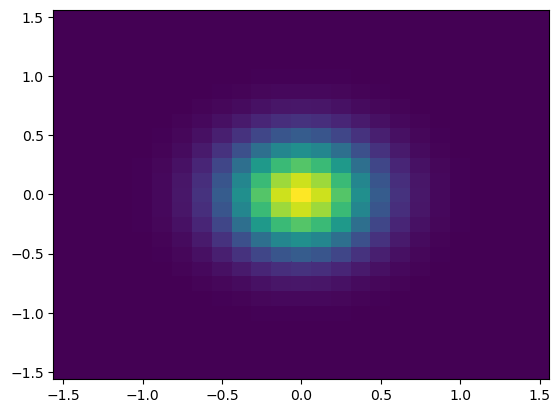

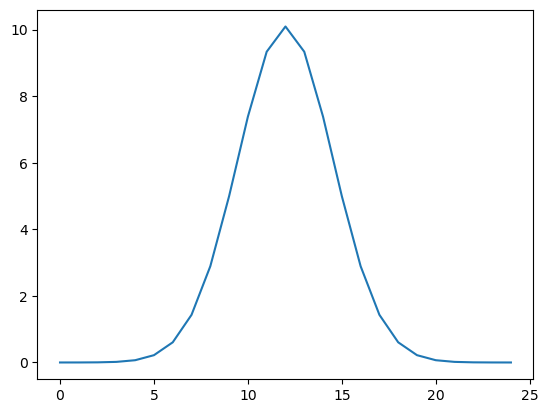

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from models import IndependentVariationalNN
from phase_space_reconstruction.histogram import histogram, histogram2d


def gt_dist(x):
    prob = torch.distributions.MultivariateNormal(
        torch.zeros(2), torch.eye(2) * 0.1
    ).log_prob(x).exp()
    return prob


def pred_probability(x, y):
    bandwidth = torch.tensor(1e-1)
    bin_width = x[1] - x[0]
    hist = histogram2d(*torch.movedim(y, -1, 0), x, x, bandwidth).squeeze()
    return hist / bin_width ** 2


# probability of data given y
def log_predictive_likelihood(x, y, target_proj, visualize=False):
    # y is tensor of particle coordiantes

    # calculate KDE of y projected onto the x axis
    pred_p = pred_probability(x, y).sum(dim=-1)

    if visualize:
        fig, ax = plt.subplots()
        ax.plot(x, pred_p.detach()[0])
        ax.plot(x, target_proj.detach())
        # ax.plot(x, (log_target_p - log_pred_p)[0].detach())

        # fig2,ax2 = plt.subplots()
        # ax2.plot(x,(log_target_p.exp()*(log_target_p - log_pred_p))[0].detach())

    # calc kl div between distributions
    # return (log_target_p.exp() * (log_target_p - log_pred_p)).sum(dim=-1)
    return torch.sum((target_proj - pred_p) ** 2, dim=-1)


n_mesh = 25
x = torch.linspace(-1.5, 1.5, n_mesh)
mesh_x = torch.meshgrid(x, x)
xx,yy = mesh_x[0].numpy(), mesh_x[1].numpy()

test_x = torch.stack(mesh_x, dim=-1)

# log target projection
gt_val = gt_dist(test_x)
gt_proj = torch.sum(gt_val, dim=-1)

fig,ax = plt.subplots()
ax.pcolor(xx, yy, gt_val)

fig2,ax2 = plt.subplots()
ax2.plot(gt_proj)


## Plot model without training

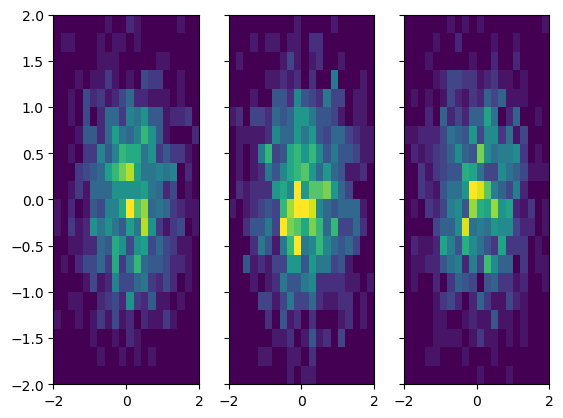

In [2]:
n_part = 1000
n_samples = 30
model = IndependentVariationalNN(n_outputs=2, n_samples=n_samples)
base_X = torch.rand(n_part, 2) * 0.01
# model = precondition(model, base_X)

out = model(base_X)
fig, ax = plt.subplots(1,3,sharex="all",sharey="all")
for i in range(3):
    ax[i].hist2d(*out[i].T.detach().numpy(), bins=20, range=((-2,2),(-2,2)))


0 tensor(142.4077, grad_fn=<MeanBackward0>) tensor(143.1959, grad_fn=<AddBackward0>) tensor(0.7881, grad_fn=<MulBackward0>)
100 tensor(123.1476, grad_fn=<MeanBackward0>) tensor(124.1279, grad_fn=<AddBackward0>) tensor(0.9803, grad_fn=<MulBackward0>)
200 tensor(105.0448, grad_fn=<MeanBackward0>) tensor(106.2522, grad_fn=<AddBackward0>) tensor(1.2074, grad_fn=<MulBackward0>)
300 tensor(80.5507, grad_fn=<MeanBackward0>) tensor(82.0232, grad_fn=<AddBackward0>) tensor(1.4725, grad_fn=<MulBackward0>)
400 tensor(52.3683, grad_fn=<MeanBackward0>) tensor(54.1430, grad_fn=<AddBackward0>) tensor(1.7747, grad_fn=<MulBackward0>)
500 tensor(30.2824, grad_fn=<MeanBackward0>) tensor(32.3449, grad_fn=<AddBackward0>) tensor(2.0625, grad_fn=<MulBackward0>)
600 tensor(14.3488, grad_fn=<MeanBackward0>) tensor(16.6506, grad_fn=<AddBackward0>) tensor(2.3018, grad_fn=<MulBackward0>)
700 tensor(5.0713, grad_fn=<MeanBackward0>) tensor(7.5349, grad_fn=<AddBackward0>) tensor(2.4637, grad_fn=<MulBackward0>)
800 te

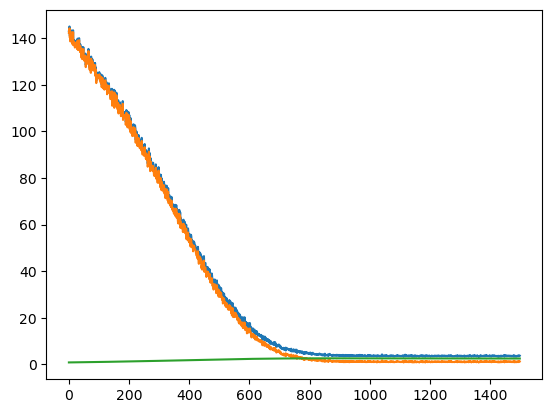

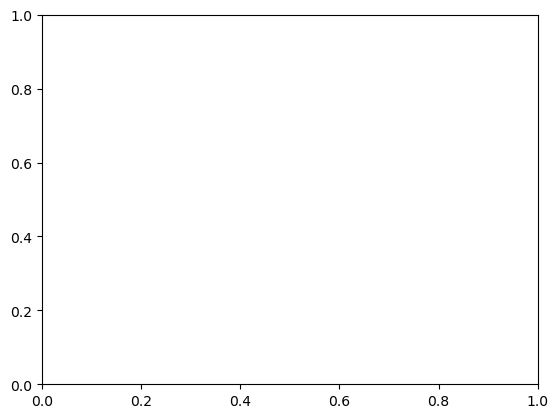

In [3]:
# train
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_track = []
for i in range(1500):
    optim.zero_grad()

    # get samples
    out = model(base_X).squeeze()

    # compute the log likelihood given the data
    log_lk = log_predictive_likelihood(x, out, gt_proj, visualize=False).mean()

    # apply a prior on the uncertainty - set a prior distribution on the uncertainty
    # to 1.0
    log_std_prior = 10.0*(model.std(base_X) - 1.0).pow(2).mean()

    # calculate loss
    loss = log_lk + log_std_prior

    loss.backward()
    loss_track += [torch.stack([loss, log_lk, log_std_prior])]

    if i % 100 == 0:
        print(i, log_lk, loss, log_std_prior)

    optim.step()

log_predictive_likelihood(x, out, gt_proj, visualize=False).mean()

loss_track = torch.stack(loss_track).detach()
fig2, ax2 = plt.subplots()
ax2.plot(loss_track)

out = model(base_X)
fig, ax = plt.subplots()

#bandwidth = torch.tensor(1e-1)
#for i in range(len(out)):
#    ax.plot(x, histogram(out[i, :, 1].detach(), x, bandwidth=bandwidth))




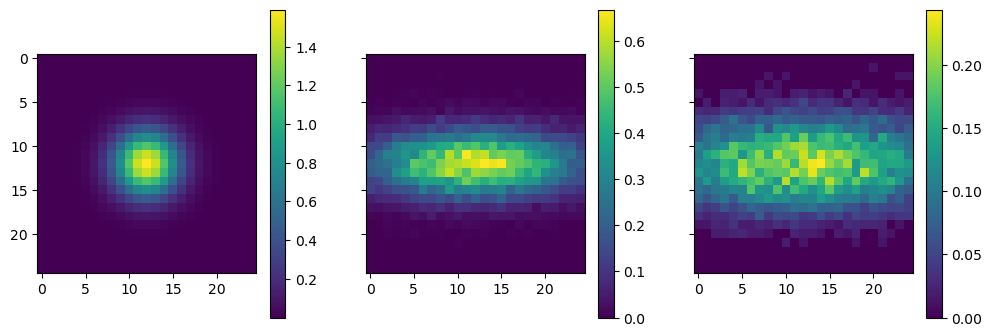

In [4]:
import numpy as np
fig, ax = plt.subplots(1,3,sharex="all",sharey="all")
fig.set_size_inches(12,4)
c = ax[0].imshow(gt_val)
fig.colorbar(c)

histograms = []
for i in range(len(out)):
    # calculate histograms
    histograms += [np.histogram2d(
        *out[i].T.detach().numpy(),
        bins=25,
        range=((-1.5,1.5),(-1.5,1.5)),
        density=True
    )[0]]

histograms = np.stack(histograms)
hist_mean = np.mean(histograms, axis=0)
hist_std = np.std(histograms, axis=0)

c =ax[1].imshow(hist_mean)
fig.colorbar(c)

c = ax[2].imshow(hist_std)
fig.colorbar(c)
#ax[1].hist2d(*out[i-1].T.detach().numpy(), bins=20, )

plt.show()

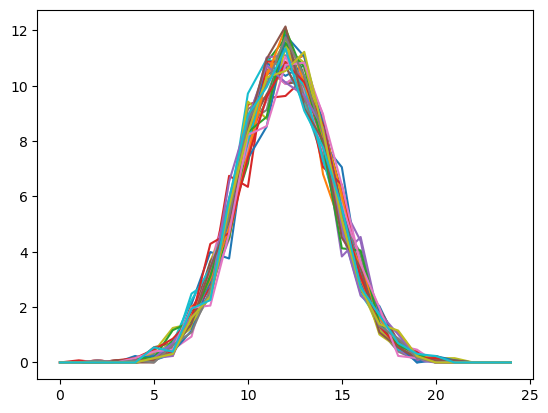

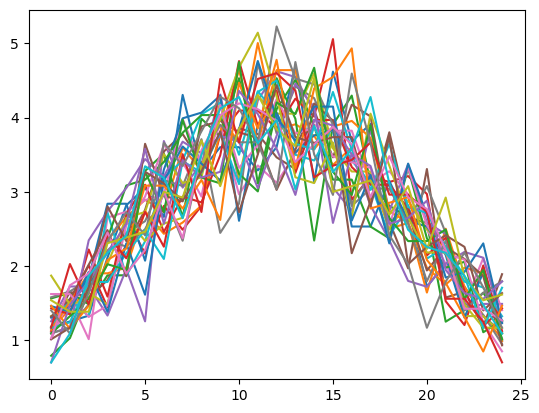

In [5]:
for i in range(len(histograms)):
    plt.plot(histograms.sum(axis=-1)[i])

plt.figure()
for i in range(len(histograms)):
    plt.plot(histograms.sum(axis=-2)[i])

In [6]:
histograms.shape

(30, 25, 25)

In [7]:
model.std(base_X)

tensor([[0.3010, 0.9326],
        [0.3013, 0.9324],
        [0.3011, 0.9325],
        ...,
        [0.3010, 0.9326],
        [0.3009, 0.9327],
        [0.3010, 0.9326]], grad_fn=<Log1PBackward0>)

In [8]:
model.mean(base_X)

tensor([[ 0.0029, -0.0043],
        [ 0.0033, -0.0041],
        [ 0.0026, -0.0046],
        ...,
        [ 0.0031, -0.0040],
        [ 0.0028, -0.0043],
        [ 0.0030, -0.0041]], grad_fn=<AddmmBackward0>)